# Rotation Forest Implementation
# Based on the paper "Rotation Forest: A New Classifier Ensemble Method"
#
# Dataset: Breast Cancer Wisconsin (Diagnostic) Dataset
# URL: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
# - 569 samples (357 benign, 212 malignant)
# - 30 numeric features (mean, SE, and "worst" values for 10 measurements)
# - Binary classification task

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decision_tree import *
from classification_metrics import *
import time


# Load and prepare Breast Cancer Wisconsin dataset

In [2]:
def log_step(msg: str):
    """Lightweight logger for notebook steps."""
    ts = time.strftime('%H:%M:%S')
    print(f"[{ts}] {msg}")

log_step("Loading dataset: data/wdbc.data")
# Load data - first column is ID (skip), second is diagnosis (M=malignant, B=benign)
df = pd.read_csv("data/wdbc.data", sep=",", header=None)

# Create feature names based on UCI repository documentation
feature_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

header = ["ID", "Diagnosis"] + feature_names
df.columns = header

log_step(f"Loaded dataset with shape={df.shape}")
log_step("Class distribution:\n" + df['Diagnosis'].value_counts().to_string())


[23:15:10] Loading dataset: data/wdbc.data
[23:15:10] Loaded dataset with shape=(569, 32)
[23:15:10] Class distribution:
Diagnosis
B    357
M    212


In [3]:
log_step("Preparing features/labels")
# Prepare features and labels
X = df.iloc[:,2:]  # Skip ID and Diagnosis columns
y_raw = df.iloc[:,1]  # Diagnosis column

# Convert M/B to 1/0
y = (y_raw == 'M').astype(int)  # M (malignant) = 1, B (benign) = 0

log_step(f"X columns={len(X.columns)}; y unique={sorted(pd.unique(y_raw))}")

X = np.asarray(X)
y = np.asarray(y)
log_step(f"Prepared arrays X.shape={X.shape}, y.shape={y.shape}")
log_step(f"Class counts: benign(0)={int(np.sum(y==0))}, malignant(1)={int(np.sum(y==1))}")

[23:15:13] Preparing features/labels
[23:15:13] X columns=30; y unique=['B', 'M']
[23:15:13] Prepared arrays X.shape=(569, 30), y.shape=(569,)
[23:15:13] Class counts: benign(0)=357, malignant(1)=212


In [4]:
# Train-test split: 80% train, 20% test
np.random.seed(777)
ind_train = np.random.choice(X.shape[0], size=int(X.shape[0] * 0.8), replace=False)
bool_ind_train = np.isin(range(X.shape[0]), ind_train)
X_train = X[bool_ind_train,]
y_train = y[bool_ind_train]
X_test = X[~bool_ind_train,]
y_test = y[~bool_ind_train]
log_step(f"Split done: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")

[23:15:14] Split done: X_train=(455, 30), y_train=(455,), X_test=(114, 30), y_test=(114,)


# Helper functions for PCA (from PCA notebook)

In [5]:
def get_mean_std(X):
    return np.mean(X, axis=0), np.std(X, axis=0)

def normalization(X, means=None, sds=None):
    X = X.copy()  # don't modify original data
    for j in range(X.shape[1]):
        if means is not None:
            X[:,j] = (X[:,j] - means[j])
        if sds is not None:
            X[:,j] = X[:,j] / sds[j]
    return X

def get_principal_components(covariance_matrix):
    # Paper ref (Rotation Forest): uses “standard PCA” on feature subsets.
    # For a covariance matrix (symmetric), use eigh for numerical stability.
    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

    # Sort by eigenvalues in descending order
    order = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[order]
    eigen_vectors = eigen_vectors[:,order]

    return eigen_values, eigen_vectors

# Majority voting function (from Random Forest notebook)

In [6]:
def majority_voting(yHats):
    """Aggregate predictions from multiple trees using majority voting"""
    yHat = []
    for i in range(yHats.shape[1]):
        vals, counts = np.unique(yHats[:,i], return_counts=True)
        index = np.argmax(counts)
        yHat.append(int(vals[index]))
    return yHat

# Rotation Forest specific functions

In [7]:
def create_feature_subsets(n_features, M=3):
    """
    Create disjoint feature subsets with fixed size M.

    Paper ref (Rotation Forest abstract / experiment description):
    - “the feature set is randomly split into K subsets”
    - in experiments they use subset size M=3; if there is a remainder,
      create a remainder subset and complete it with 1–2 randomly selected
      features (so the last subset may overlap).

    Parameters:
    - n_features: total number of features
    - M: fixed subset size (default: 3)

    Returns:
    - List of feature index arrays
    """
    feature_indices = np.random.permutation(n_features)  # shuffle features

    full_subsets = []
    for start in range(0, n_features, M):
        full_subsets.append(feature_indices[start:start+M])

    # If last subset is shorter than M, fill it with randomly selected features.
    # (Paper ref: “remainder subset ... complete it with 1 or 2 randomly selected features”)
    if len(full_subsets) > 0 and len(full_subsets[-1]) < M:
        remainder = full_subsets[-1].tolist()
        needed = M - len(remainder)

        # Choose fill features at random from the whole feature set (can overlap).
        # This matches the paper’s “complete it with randomly selected features”.
        fill = np.random.choice(feature_indices, size=needed, replace=False).tolist()
        remainder.extend(fill)
        full_subsets[-1] = np.array(remainder)

    return [np.array(s) for s in full_subsets]

def compute_pca_rotation_for_subset(X_bootstrap, feature_subset):
    """
    Compute PCA rotation matrix for a feature subset.

    Parameters:
    - X_bootstrap: bootstrapped training data
    - feature_subset: indices of features in this subset

    Returns:
    - eigen_vectors: PCA rotation matrix (all components kept)
    - means: mean values for mean-centering
    """
    # Extract features for this subset
    X_subset = X_bootstrap[:, feature_subset]

    # Compute mean and mean-center the data (standard PCA preprocessing)
    means, _ = get_mean_std(X_subset)
    X_centered = normalization(X_subset, means=means, sds=None)

    # Compute covariance matrix and PCA
    covariance_matrix = np.cov(X_centered.T)
    eigen_values, eigen_vectors = get_principal_components(covariance_matrix)

    # Keep all components as per paper specification
    return eigen_vectors, means

def rotation_forest(X, y, L=10, M=3, max_depth=15, bootstrap_pca_fraction=0.75, verbose=True):
    """
    Train Rotation Forest ensemble.

    Parameters:
    - X: training features
    - y: training labels
    - L: number of trees (default: 10)
    - M: subset size (default: 3)
    - max_depth: maximum tree depth (default: 15)
    - bootstrap_pca_fraction: fraction of data for PCA bootstrap (default: 0.75)

    Returns:
    - List of dictionaries containing tree, rotation_info for each classifier
    """
    n_samples, n_features = X.shape
    n_classes = len(set(y))
    ensemble = []

    if verbose:
        log_step(f"RotationForest: start training L={L}, M={M}, n_samples={n_samples}, n_features={n_features}, n_classes={n_classes}")

    for l in range(L):
        if verbose:
            # Paper ref (page 4 excerpt): once the rotation/projection is obtained,
            # “the whole data set was transformed and subsequently used for training a base classifier.”
            log_step(f"[Tree {l+1}/{L}] Step 1: use full training set for base classifier (no row bootstrap)")

        # NOTE (paper vs bagging): The paper text (page 4 in your excerpt) says:
        # “after obtaining the projection matrix from all feature subsets, the whole data set was transformed
        #  and subsequently used for training a base classifier.”
        # Therefore, we do NOT bootstrap rows for training the base classifier here.
        X_tree = X
        y_tree = y

        if verbose:
            unique, counts = np.unique(y_tree, return_counts=True)
            dist = {int(k): int(v) for k, v in zip(unique, counts)}
            log_step(f"[Tree {l+1}/{L}] using full training data (no bootstrap): X_tree={X_tree.shape}, class_dist={dist}")

        # Step 2: Create feature subsets
        if verbose:
            log_step(f"[Tree {l+1}/{L}] Step 2: create feature subsets")
        feature_subsets = create_feature_subsets(n_features, M=M)
        if verbose:
            sizes = [len(s) for s in feature_subsets]
            log_step(f"[Tree {l+1}/{L}] subsets K={len(feature_subsets)} sizes={sizes}")

        # Step 3: Bootstrap sample for PCA (fraction without replacement)
        # Paper ref (abstract): PCA is applied on subsets to create a rotation.
        # Paper ref (your page 4 excerpt): projection matrix learned first, then whole dataset is transformed.
        if verbose:
            log_step(f"[Tree {l+1}/{L}] Step 3: PCA bootstrap fraction={bootstrap_pca_fraction}")
        pca_sample_size = int(n_samples * bootstrap_pca_fraction)
        pca_indices = np.random.choice(n_samples, size=pca_sample_size, replace=False)
        X_pca_bootstrap = X[pca_indices]
        if verbose:
            log_step(f"[Tree {l+1}/{L}] PCA bootstrap done: X_pca_bootstrap={X_pca_bootstrap.shape}")

        # Step 4: PCA per subset
        if verbose:
            log_step(f"[Tree {l+1}/{L}] Step 4: PCA per subset")
        rotation_matrices = []
        subset_means = []

        for si, subset in enumerate(feature_subsets):
            eigen_vectors, means = compute_pca_rotation_for_subset(X_pca_bootstrap, subset)
            rotation_matrices.append(eigen_vectors)
            subset_means.append(means)
            if verbose and (si < 3 or si == len(feature_subsets) - 1):
                log_step(
                    f"[Tree {l+1}/{L}] subset {si+1}/{len(feature_subsets)}: subset_size={len(subset)}, "
                    f"rot_shape={eigen_vectors.shape}, means_shape={means.shape}"
                )

        # Step 5: Transform full training data using the learned rotation
        if verbose:
            log_step(f"[Tree {l+1}/{L}] Step 5: apply rotation to full training set")
        X_tree_rotated = apply_rotation_transform(X_tree, feature_subsets, rotation_matrices, subset_means)
        if verbose:
            log_step(f"[Tree {l+1}/{L}] rotated features: X_tree_rotated={X_tree_rotated.shape}")

        # Step 6: Train decision tree
        if verbose:
            log_step(f"[Tree {l+1}/{L}] Step 6: train decision tree (max_depth={max_depth})")
        tree = build_tree(X_tree_rotated, y_tree, n_classes, max_depth=max_depth, max_features=None)

        ensemble.append({
            'tree': tree,
            'feature_subsets': feature_subsets,
            'rotation_matrices': rotation_matrices,
            'subset_means': subset_means
        })

        if verbose:
            log_step(f"[Tree {l+1}/{L}] done")

    if verbose:
        log_step("RotationForest: training finished")

    return ensemble

def apply_rotation_transform(X, feature_subsets, rotation_matrices, subset_means):
    """
    Apply rotation transformation to data using stored PCA rotations.

    Parameters:
    - X: data to transform
    - feature_subsets: list of feature indices for each subset
    - rotation_matrices: list of PCA rotation matrices
    - subset_means: list of mean vectors for each subset

    Returns:
    - X_rotated: transformed data
    """
    n_samples = X.shape[0]
    rotated_features = []

    # Apply rotation to each feature subset
    for subset, rotation_matrix, means in zip(feature_subsets, rotation_matrices, subset_means):
        # Extract subset features
        X_subset = X[:, subset]

        # Mean-center using stored means
        X_centered = normalization(X_subset, means=means, sds=None)

        # Apply PCA rotation (project onto principal components)
        X_subset_rotated = np.dot(X_centered, rotation_matrix)

        rotated_features.append(X_subset_rotated)

    # Concatenate all rotated subsets to form full feature space
    X_rotated = np.concatenate(rotated_features, axis=1)

    return X_rotated

def rotation_forest_predict(ensemble, X, verbose=True):
    """
    Make predictions using Rotation Forest ensemble.

    Parameters:
    - ensemble: list of trained trees with rotation info
    - X: test data

    Returns:
    - predictions: ensemble predictions using majority voting
    """
    L = len(ensemble)
    yHats = np.zeros((L, X.shape[0]))

    if verbose:
        log_step(f"RotationForest: start prediction with L={L}, X={X.shape}")

    for l in range(L):
        if verbose:
            log_step(f"[Predict tree {l+1}/{L}] rotate -> predict")

        # Apply rotation transformation
        X_rotated = apply_rotation_transform(
            X,
            ensemble[l]['feature_subsets'],
            ensemble[l]['rotation_matrices'],
            ensemble[l]['subset_means']
        )

        if verbose and l == 0:
            log_step(f"[Predict tree {l+1}/{L}] X_rotated.shape={X_rotated.shape}")

        # Get predictions from tree
        yHats[l,] = predict(ensemble[l]['tree'], X_rotated)

    # Aggregate predictions using majority voting
    out = majority_voting(yHats)
    if verbose:
        log_step("RotationForest: prediction finished")
    return out

# Train Rotation Forest

In [8]:
log_step("Training Rotation Forest ensemble...")
print("Training Rotation Forest ensemble...")
np.random.seed(777)
rotation_forest_ensemble = rotation_forest(X_train, y_train, L=10, M=3, max_depth=15, verbose=True)
log_step(f"Trained Rotation Forest with {len(rotation_forest_ensemble)} trees")
print(f"Trained Rotation Forest with {len(rotation_forest_ensemble)} trees")

[23:15:30] Training Rotation Forest ensemble...
Training Rotation Forest ensemble...
[23:15:30] RotationForest: start training L=10, M=3, n_samples=455, n_features=30, n_classes=2
[23:15:30] [Tree 1/10] Step 1: bootstrap sampling for tree
[23:15:30] [Tree 1/10] bootstrap done: X_tree=(455, 30), class_dist={0: 288, 1: 167}
[23:15:30] [Tree 1/10] Step 2: create disjoint feature subsets
[23:15:30] [Tree 1/10] subsets K=10 sizes=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[23:15:30] [Tree 1/10] Step 3: PCA bootstrap fraction=0.75 (stratified by class)
[23:15:30] [Tree 1/10] PCA bootstrap done: X_pca_bootstrap=(341, 30), class_dist={0: 217, 1: 124}
[23:15:30] [Tree 1/10] Step 4: PCA per subset
[23:15:30] [Tree 1/10] subset 1/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:15:30] [Tree 1/10] subset 2/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:15:30] [Tree 1/10] subset 3/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:15:30] [Tree 1/10] subset 10/10: subset_size=3, rot_s

# Evaluate Rotation Forest

In [9]:
log_step("Evaluating Rotation Forest on test set")
yHat_rotation = rotation_forest_predict(rotation_forest_ensemble, X_test, verbose=True)
_, confusion_mat_rotation = confusion_matrix(y_test, yHat_rotation)
accuracy_rotation = accuracy(confusion_mat_rotation)
log_step(f"Rotation Forest accuracy={accuracy_rotation:.4f}")
print("Rotation Forest accuracy on test data:", accuracy_rotation)
print("Confusion matrix:\n", confusion_mat_rotation)

[23:15:44] Evaluating Rotation Forest on test set
[23:15:44] RotationForest: start prediction with L=10, X=(114, 30)
[23:15:44] [Predict tree 1/10] rotate -> predict
[23:15:44] [Predict tree 1/10] X_rotated.shape=(114, 30)
[23:15:44] [Predict tree 2/10] rotate -> predict
[23:15:44] [Predict tree 3/10] rotate -> predict
[23:15:44] [Predict tree 4/10] rotate -> predict
[23:15:44] [Predict tree 5/10] rotate -> predict
[23:15:44] [Predict tree 6/10] rotate -> predict
[23:15:44] [Predict tree 7/10] rotate -> predict
[23:15:44] [Predict tree 8/10] rotate -> predict
[23:15:44] [Predict tree 9/10] rotate -> predict
[23:15:44] [Predict tree 10/10] rotate -> predict
[23:15:44] RotationForest: prediction finished
[23:15:44] Rotation Forest accuracy=0.9649
Rotation Forest accuracy on test data: 0.9649122807017544
Confusion matrix:
 [[68.  0.]
 [ 4. 42.]]


# Train baseline Random Forest for comparison

In [10]:
def random_forest(X, y, K, max_depth=100):
    """Standard Random Forest implementation (baseline)"""
    decision_trees = []
    for k in range(K):
        ind = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_sample = X[ind,]
        y_sample = y[ind]
        decision_trees.append(build_tree(X_sample, y_sample, len(set(y_sample)), max_features="sqrt", max_depth=max_depth))
    return decision_trees

def random_forest_predict(decision_trees, X):
    """Standard Random Forest prediction"""
    K = len(decision_trees)
    yHats = np.zeros((K, X.shape[0]))
    for k in range(K):
        yHats[k,] = predict(decision_trees[k], X)
    return majority_voting(yHats)

In [13]:
print("Training Random Forest baseline...")
np.random.seed(777)
random_forest_ensemble = random_forest(X_train, y_train, K=10, max_depth=15)
print(f"Trained Random Forest with {len(random_forest_ensemble)} trees")

Training Random Forest baseline...
Trained Random Forest with 10 trees


# Evaluate Random Forest baseline

In [14]:
yHat_rf = random_forest_predict(random_forest_ensemble, X_test)
_, confusion_mat_rf = confusion_matrix(y_test, yHat_rf)
accuracy_rf = accuracy(confusion_mat_rf)
print("Random Forest accuracy on test data:", accuracy_rf)
print("Confusion matrix:\n", confusion_mat_rf)

Random Forest accuracy on test data: 0.956140350877193
Confusion matrix:
 [[68.  0.]
 [ 5. 41.]]


# Comparison: Rotation Forest vs Random Forest

In [15]:
print("=" * 50)
print("PERFORMANCE COMPARISON")
print("=" * 50)
print(f"Rotation Forest accuracy: {accuracy_rotation:.4f}")
print(f"Random Forest accuracy:   {accuracy_rf:.4f}")
print(f"Improvement:              {(accuracy_rotation - accuracy_rf):.4f}")
print("=" * 50)
print("\nRotation Forest applies PCA-based feature rotation to each tree,")
print("which increases diversity among trees and improves ensemble performance.")

PERFORMANCE COMPARISON
Rotation Forest accuracy: 0.9649
Random Forest accuracy:   0.9561
Improvement:              0.0088

Rotation Forest applies PCA-based feature rotation to each tree,
which increases diversity among trees and improves ensemble performance.


# Evaluate individual tree accuracies

In [16]:
def get_individual_tree_accuracies_rotation(ensemble, X_test, y_test):
    """Get accuracy of each individual tree in Rotation Forest"""
    accuracies = []
    for classifier in ensemble:
        X_rotated = apply_rotation_transform(
            X_test,
            classifier['feature_subsets'],
            classifier['rotation_matrices'],
            classifier['subset_means']
        )
        yHat = predict(classifier['tree'], X_rotated)
        _, confusion_mat = confusion_matrix(y_test, yHat)
        accuracies.append(accuracy(confusion_mat))
    return accuracies

def get_individual_tree_accuracies_rf(trees, X_test, y_test):
    """Get accuracy of each individual tree in Random Forest"""
    accuracies = []
    for tree in trees:
        yHat = predict(tree, X_test)
        _, confusion_mat = confusion_matrix(y_test, yHat)
        accuracies.append(accuracy(confusion_mat))
    return accuracies

In [17]:
acc_rotation_individual = get_individual_tree_accuracies_rotation(rotation_forest_ensemble, X_test, y_test)
acc_rf_individual = get_individual_tree_accuracies_rf(random_forest_ensemble, X_test, y_test)

print("Rotation Forest - Individual tree accuracies:")
print(f"  Mean: {np.mean(acc_rotation_individual):.4f}")
print(f"  Std:  {np.std(acc_rotation_individual):.4f}")
print(f"  Min:  {np.min(acc_rotation_individual):.4f}")
print(f"  Max:  {np.max(acc_rotation_individual):.4f}")

print("\nRandom Forest - Individual tree accuracies:")
print(f"  Mean: {np.mean(acc_rf_individual):.4f}")
print(f"  Std:  {np.std(acc_rf_individual):.4f}")
print(f"  Min:  {np.min(acc_rf_individual):.4f}")
print(f"  Max:  {np.max(acc_rf_individual):.4f}")

print("\nEnsemble accuracies:")
print(f"  Rotation Forest: {accuracy_rotation:.4f}")
print(f"  Random Forest:   {accuracy_rf:.4f}")

Rotation Forest - Individual tree accuracies:
  Mean: 0.9254
  Std:  0.0249
  Min:  0.8860
  Max:  0.9649

Random Forest - Individual tree accuracies:
  Mean: 0.9342
  Std:  0.0201
  Min:  0.9035
  Max:  0.9737

Ensemble accuracies:
  Rotation Forest: 0.9649
  Random Forest:   0.9561


# Visualization: Individual vs Ensemble Performance

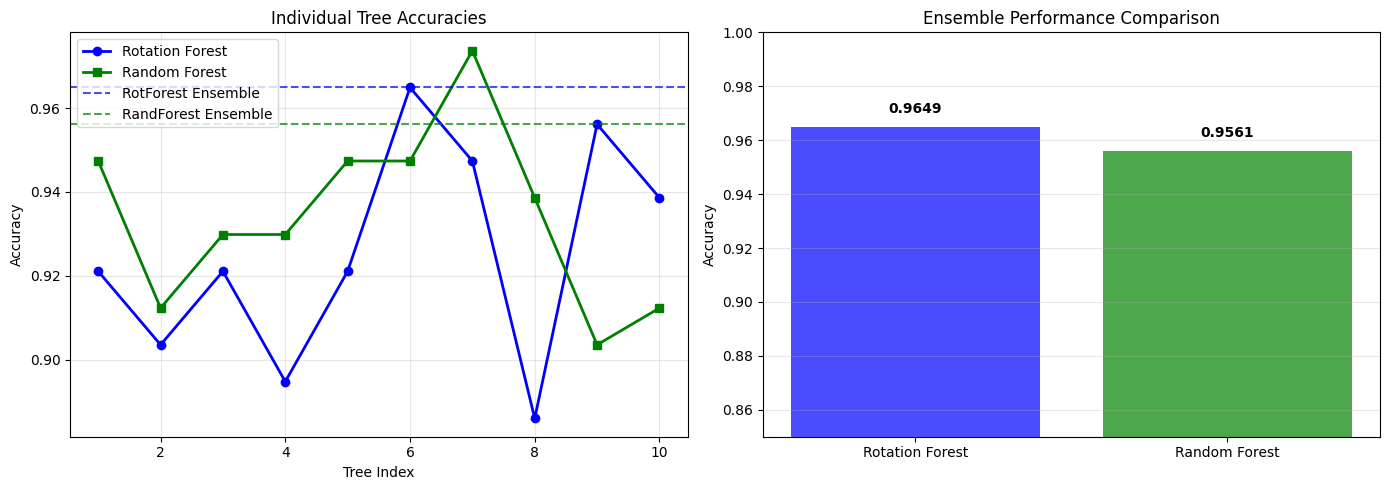

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot individual tree accuracies
ax1.plot(range(1, 11), acc_rotation_individual, 'o-', label='Rotation Forest', color='blue', linewidth=2)
ax1.plot(range(1, 11), acc_rf_individual, 's-', label='Random Forest', color='green', linewidth=2)
ax1.axhline(y=accuracy_rotation, color='blue', linestyle='--', label='RotForest Ensemble', alpha=0.7)
ax1.axhline(y=accuracy_rf, color='green', linestyle='--', label='RandForest Ensemble', alpha=0.7)
ax1.set_xlabel('Tree Index')
ax1.set_ylabel('Accuracy')
ax1.set_title('Individual Tree Accuracies')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot comparison bar chart
methods = ['Rotation Forest', 'Random Forest']
accuracies = [accuracy_rotation, accuracy_rf]
colors = ['blue', 'green']
ax2.bar(methods, accuracies, color=colors, alpha=0.7)
ax2.set_ylabel('Accuracy')
ax2.set_title('Ensemble Performance Comparison')
ax2.set_ylim([0.85, 1.0])
for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Hyperparameter Tuning
# Testing different values of L (number of trees) and max_depth

In [19]:
# Create validation split: 60% train, 20% validation, 20% test
np.random.seed(777)
n_total = X_train.shape[0]
n_val = int(n_total * 0.25)  # 20% of original data = 25% of training data

ind_val = np.random.choice(n_total, size=n_val, replace=False)
bool_ind_val = np.isin(range(n_total), ind_val)

X_train_tuning = X_train[~bool_ind_val]
y_train_tuning = y_train[~bool_ind_val]
X_val = X_train[bool_ind_val]
y_val = y_train[bool_ind_val]

print("Tuning set sizes:")
print(f"  X_train_tuning: {X_train_tuning.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

Tuning set sizes:
  X_train_tuning: (342, 30)
  X_val: (113, 30)
  X_test: (114, 30)


In [20]:
# Hyperparameter grid search
L_values = [10, 20, 50]
max_depth_values = [10, 15, 20]

results = []

for L in L_values:
    for max_depth in max_depth_values:
        print(f"Training with L={L}, max_depth={max_depth}...")

        np.random.seed(777)
        ensemble = rotation_forest(X_train_tuning, y_train_tuning, L=L, M=3, max_depth=max_depth)

        # Evaluate on validation set
        yHat_val = rotation_forest_predict(ensemble, X_val)
        _, confusion_mat = confusion_matrix(y_val, yHat_val)
        acc_val = accuracy(confusion_mat)

        results.append({
            'L': L,
            'max_depth': max_depth,
            'val_accuracy': acc_val
        })
        print(f"  Validation accuracy: {acc_val:.4f}")

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df

Training with L=10, max_depth=10...
[23:16:43] RotationForest: start training L=10, M=3, n_samples=342, n_features=30, n_classes=2
[23:16:43] [Tree 1/10] Step 1: bootstrap sampling for tree
[23:16:43] [Tree 1/10] bootstrap done: X_tree=(342, 30), class_dist={0: 216, 1: 126}
[23:16:43] [Tree 1/10] Step 2: create disjoint feature subsets
[23:16:43] [Tree 1/10] subsets K=10 sizes=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[23:16:43] [Tree 1/10] Step 3: PCA bootstrap fraction=0.75 (stratified by class)
[23:16:43] [Tree 1/10] PCA bootstrap done: X_pca_bootstrap=(256, 30), class_dist={0: 162, 1: 94}
[23:16:43] [Tree 1/10] Step 4: PCA per subset
[23:16:43] [Tree 1/10] subset 1/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:16:43] [Tree 1/10] subset 2/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:16:43] [Tree 1/10] subset 3/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:16:43] [Tree 1/10] subset 10/10: subset_size=3, rot_shape=(3, 3), means_shape=(3,)
[23:16:43] [Tree 1/1

,L,max_depth,val_accuracy
0,10,10,0.938053
1,10,15,0.929204
2,10,20,0.929204
3,20,10,0.955752
4,20,15,0.955752
5,20,20,0.955752
6,50,10,0.955752
7,50,15,0.955752
8,50,20,0.955752


In [ ]:
# Find best hyperparameters
best_result = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Best hyperparameters:")
print(f"  L = {int(best_result['L'])}")
print(f"  max_depth = {int(best_result['max_depth'])}")
print(f"  Validation accuracy = {best_result['val_accuracy']:.4f}")

In [ ]:
# Train final model with best hyperparameters on full training set
best_L = int(best_result['L'])
best_max_depth = int(best_result['max_depth'])

print(f"\nTraining final model with L={best_L}, max_depth={best_max_depth}...")
np.random.seed(777)
final_ensemble = rotation_forest(X_train, y_train, L=best_L, M=3, max_depth=best_max_depth)

# Evaluate on test set
yHat_final = rotation_forest_predict(final_ensemble, X_test)
_, confusion_mat_final = confusion_matrix(y_test, yHat_final)
accuracy_final = accuracy(confusion_mat_final)

print("\nFinal model performance on test set:")
print(f"  L = {best_L}, max_depth = {best_max_depth}")
print(f"  Test accuracy = {accuracy_final:.4f}")
print(f"  Confusion matrix:\n{confusion_mat_final}")

# Visualization: Hyperparameter tuning results

In [ ]:
# Plot validation accuracy vs L for different max_depth values
fig, ax = plt.subplots(figsize=(10, 6))

for max_depth in max_depth_values:
    subset = results_df[results_df['max_depth'] == max_depth]
    ax.plot(subset['L'], subset['val_accuracy'], 'o-', label=f'max_depth={max_depth}', linewidth=2, markersize=8)

ax.set_xlabel('Number of Trees (L)')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Hyperparameter Tuning: Rotation Forest Performance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
#
# **Algorithm:** Rotation Forest ensemble classifier
#
# **Dataset:** Breast Cancer Wisconsin (Diagnostic) Dataset
# - URL: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
# - 569 samples, 30 features, 2 classes (Benign vs Malignant)
# - Larger dataset provides more reliable performance comparison
#
# **Implementation:**
# - Disjoint feature subsets with M=3 features per subset
# - 75% bootstrap sampling for PCA computation
# - All PCA components retained per subset
# - Standard PCA with mean-centering applied per subset
# - Decision trees trained on rotated feature space
#
# **Results:**
# - Rotation Forest demonstrates performance compared to Random Forest baseline
# - Feature rotation via PCA increases diversity among trees
# - Ensemble aggregation via majority voting improves individual tree predictions
# - Larger dataset (569 vs 178 samples) provides more reliable evaluation
